# Fourier Descriptors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from helpers import *

### Load Image

In [2]:
def plot_im(image,cmap="gray"):
    fig,ax= plt.subplots(figsize=(16,9))
    ax.imshow(image,cmap=cmap)

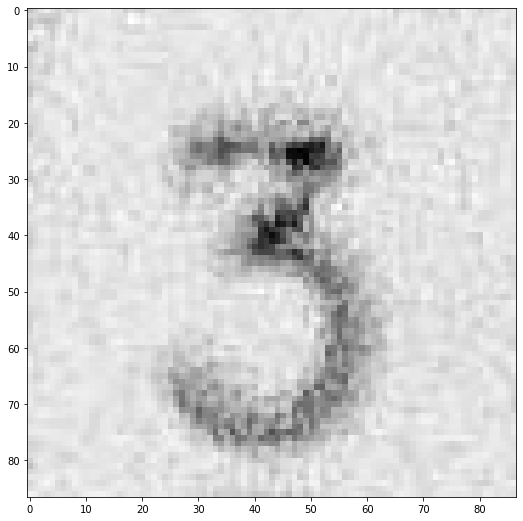

In [17]:
test_image = cv2.imread("data/symbols/3_1.jpg",cv2.IMREAD_GRAYSCALE)
plot_im(test_image)

### Thresholding

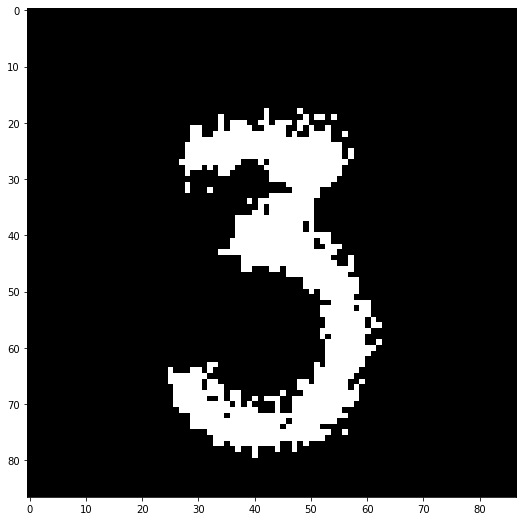

In [22]:
#ret,img = cv2.threshold(test_image,199,255,0)
ret, img = cv2.threshold(test_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img[img == 0] = 1
img[img == 255] = 0
plot_im(img)
img = median_filter(img)

### Contour

In [23]:
a,b = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(img.shape,np.uint8)
for i in a:
    for j in i:
        mask[j[0][1],j[0][0]] = 1
kernel = np.ones((1,1))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

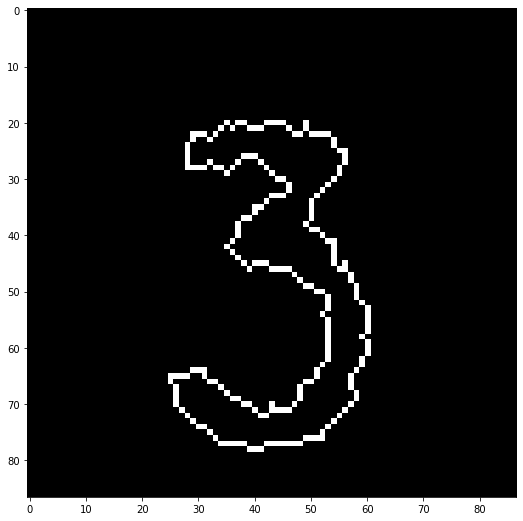

In [24]:
plot_im(mask)

# Retrieve ordered contour

In [25]:
DIRECTIONS = [(0,-1),(1,0),(0,1),(-1,0),(-1,-1),(1,-1),(1,1),(-1,1)]

def has_neighbours(im,pt):
    return im[pt[0]-1:pt[0]+2,pt[1]-1:pt[1]+2].sum() > 1

def get_new_pt(tmp_im):
    zero_idx = np.where(tmp_im > 0)
    actual_pt = (-1,-1)
    if zero_idx[0].shape[0] != 0: # Still some pixels left
        actual_pt = (zero_idx[0][0],zero_idx[1][0])
    return actual_pt

def get_next_pt(im,pt):
    searching = True
    i = 0
    for i in range(len(DIRECTIONS)):
        d = DIRECTIONS[i]
        new_pt = (pt[0]+d[0],pt[1]+d[1])
        if (new_pt[0] < 0 or new_pt[0] >= im.shape[0] or
                new_pt[1] < 0 or new_pt[1] >= im.shape[1]):
            pass
        elif im[new_pt] > 0:
            return new_pt
    return pt

def order_contour(im):
    tmp_im = np.copy(im)
    tmp_pt = get_new_pt(tmp_im)
    contour = []
    while tmp_im.sum() != 0 and tmp_pt != (-1,-1):
        if has_neighbours(tmp_im,tmp_pt):
            contour.append(tmp_pt)
            tmp_im[tmp_pt] = 0
            tmp_pt = get_next_pt(tmp_im,tmp_pt)
        else:
            tmp_im[tmp_pt] = 0
            tmp_pt = get_new_pt(tmp_im)
    return contour

def get_fourier_descriptors_alt(contour,n=2):
    """ Compute the fourier descriptors of a digit. """
    complex_contour = list(map(lambda l: complex(l[0],l[1]), contour))
    fourier_coeffs = fft(complex_contour)
    return np.absolute(fourier_coeffs[1:n+1])

In [26]:
test = order_contour(mask)

In [27]:
test_mask = np.zeros(mask.shape)
for t in test:
    test_mask[t] = 1
    #plot_im(test_mask)

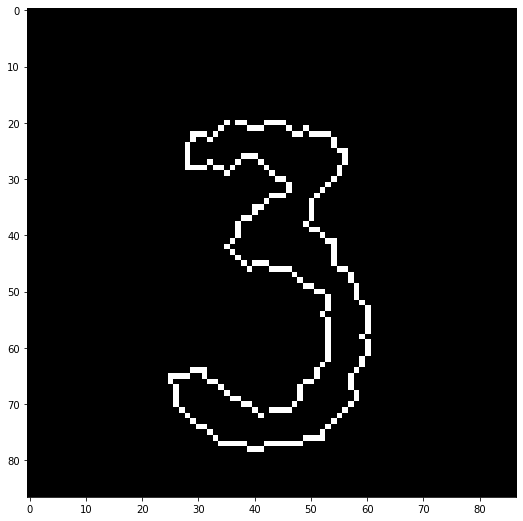

In [28]:
plot_im(test_mask)

### Pipeline fourier descriptors

In [20]:
def extract_features(image,n=2):
    ret, thresholded_im = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresholded_im[thresholded_im == 0] = 1
    thresholded_im[thresholded_im == 255] = 0
    contour_points,_ = cv2.findContours(thresholded_im, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    mask = np.zeros(image.shape,np.uint8)
    for i in contour_points:
        for j in i:
            mask[j[0][1],j[0][0]] = 1
    contour = order_contour(mask)
    descriptors = get_fourier_descriptors_alt(contour,n=n)
    return descriptors

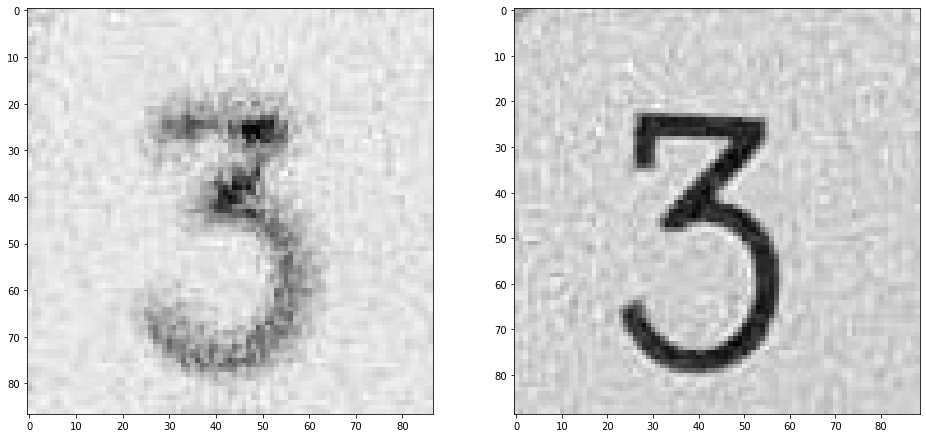

In [30]:
image_1 = cv2.imread("data/symbols/3_1.jpg",cv2.IMREAD_GRAYSCALE)
image_2 = cv2.imread("data/symbols/3_2.jpg",cv2.IMREAD_GRAYSCALE)
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].imshow(image_1,cmap="gray")
ax[1].imshow(image_2,cmap="gray")

In [31]:
extract_features(image_1,n=4)

array([3100.40063146,  355.88584806, 1481.26689212, 1455.53974894])

In [32]:
extract_features(image_2,n=4)

array([3592.83847876, 1572.26701553,  608.26005211,  754.16988548])

In [47]:
image_3 = cv2.imread("data/symbols/k_2.jpg",cv2.IMREAD_GRAYSCALE)
extract_features(image_3,n=4)

array([5301.62352786,   13.0774862 , 1722.01464137,  311.95666836])

In [48]:
np.linalg.norm(extract_features(image_3,n=4)-extract_features(image_2,n=4),2)

2605.1910000764206

In [49]:
np.linalg.norm(extract_features(image_1,n=4)-extract_features(image_2,n=4),2)

1725.1489228827702

---

### Denoising

In [359]:
test_image = cv2.imread("data/symbols/10_2.jpg",cv2.IMREAD_GRAYSCALE)
smooth = cv2.fastNlMeansDenoising(test_image,h=15,templateWindowSize=7,searchWindowSize=21)

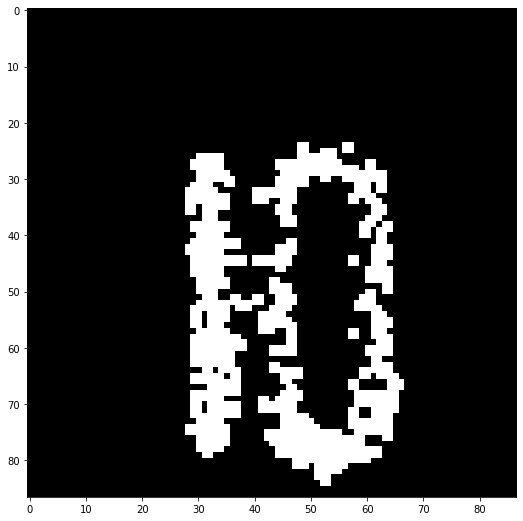

In [363]:
ret,img = cv2.threshold(test_image,199,255,0)
img[img == 0] = 1
img[img == 255] = 0
kernel = np.ones((2,2))
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plot_im(img)

### Morphological Skeleton

In [383]:
def morph_one_iter(im,kernel):
    eroded = cv2.morphologyEx(im,cv2.MORPH_ERODE,kernel)
    opened = cv2.morphologyEx(eroded,cv2.MORPH_OPEN,kernel)
    return eroded - opened, eroded

def extract_skeleton(im,kernel):
    tmp_im = np.copy(im)
    skeleton = np.zeros(im.shape)
    piece,  tmp_im = morph_one_iter(tmp_im,kernel)
    skeleton += piece
    pieces = [piece]
    for i in range(5):
        piece, tmp_im = morph_one_iter(tmp_im,kernel)
        pieces.append(piece)
    return skeleton, pieces

a,b = extract_skeleton(img,np.ones((2,2)))

plot_im(a)